In [67]:
import os
import sys 
import yaml
path_folder = '/home/bdebian/Documents/Projects/Stoke_prediccition/app_prediction/'
omitir = ''

def search_subfolders(path:str):
    '''Funcion para agregar rutas al path de ejecucion'''
    folder = []
    for root, dirs, _ in os.walk(path, topdown=False):
        for name in dirs:
            if name == omitir:
                print(f"[INFO] carpeta omitida: {name}")
            else:
                folder.append(os.path.join(root, name))
    return folder


for i in search_subfolders(path_folder):
    sys.path.insert(0, i)


from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib.dates as mdates
import seaborn as sbn

import numpy as np
import pandas as pd
from scipy import stats
import json
from class_load import LoadFiles
from factory_data import get_data, SQLDataSourceFactory
from factory_models import ModelContext, Modelos
from args_data_model import (
    ModelRNN,
    ModelBlockRNN,
    ModelExponentialSmoothing,
    ModelTCNModel,
    ModelFFT,
    ModelTransformerModel,
    ModelNBEATSModel,
    ModelDLinearModel,
    ModelNlinearModel,
    ModelTFTModel
)
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts import TimeSeries
# from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.missing_values import fill_missing_values
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.datasets import EnergyDataset,AirPassengersDataset
from darts.metrics import mape, r2_score, mse,mase,rmse,rho_risk

from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    TFTModel,
    FFT,
    ExponentialSmoothing,
    DLinearModel,
    NLinearModel
)
from factory_prepare_data import DataCleaner,MeanImputation,OutliersToIQRMean,DataModel

In [2]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "R2: {}".format(r2_score(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()

In [3]:
from class_load import LoadFiles
import torch
from pathlib import Path
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from DP_model import ModelHyperparameters, Modelos, Parameters_model
from darts.metrics import smape
import optuna
from optuna.integration import PyTorchLightningPruningCallback

In [4]:
CONFIG_FILE = "/home/bdebian/Documents/Projects/Stoke_prediccition/app_prediction/src/data/config/config.yaml"
with open(CONFIG_FILE, 'r', encoding='utf-8') as file:
    parameters = yaml.safe_load(file)
data = get_data(SQLDataSourceFactory(**parameters))

#Reempplazo de los tipo de datos por lo cuales 
#se va a cambiar el dataframe
new_types =[np.datetime64,int,int,'object',int,int]

#Estrategias para imputar los datos faltantes de NA 
strategy = {
    int:np.mean,
    float:np.mean,
    object:stats.mode
}

#metodo para transformar los tipo de datos
replace = {
    int:lambda x: int(float(x.replace(',',''))),
    float:lambda x: float(x.replace(',',''))
}

imputation = MeanImputation(
    replace_dtypes=new_types,
    strategy_imputation=strategy,
    preprocess_function=replace,
    **parameters
)

cleaner = DataCleaner(imputation)
data_for_process = cleaner.clean(data)


outliners = OutliersToIQRMean(
    **parameters
)
# outliners.clean(data_for_process.dataframe)
cleaner.strategy = outliners
filter_data = cleaner.clean(data_for_process.dataframe)

data_for_model = DataModel(**parameters)
cleaner.strategy = data_for_model

data_ready = cleaner.clean(filter_data)

data_,scalesr = data_ready
inverse_scale = scalesr.inverse_transform(data_)

In [7]:
handle_loader = LoadFiles()
save_parameters = Path('/home/bdebian/Documents/Projects/Stoke_prediccition/app_prediction/src/data/save_models')
for filter_list in parameters['filter_data']:
    if 'feature' in filter_list:
        save_parameters = save_parameters.joinpath(str(parameters['filter_data'][filter_list]))

if not os.path.isdir(save_parameters):
    os.makedirs(save_parameters.as_posix())

scaler_save_folder = save_parameters.joinpath('scaler').with_suffix('.pkl')

handle_loader.save_scaler(scalesr,scaler_save_folder)
scaler_loaded = handle_loader.load_scaler(scaler_save_folder)

In [109]:
# from factory_models import ModelContext, Modelos, Parameters_model

# model_names = list(Modelos.keys())

# for use_models in model_names:
    
#     model_dict = Parameters_model[use_models]
#     model_used_parameters = model_dict().__dict__
#     inst_model = Modelos[use_models]
#     model_prepare = inst_model(**model_used_parameters)
#     print(model_prepare)

In [64]:
class ModelHyperparameters:
    '''
    Metodo para hiperparametrizar modelos y buscar sus parametros
    '''  
    def __init__(self,model_name,data,split) -> None:
        #Nombre del modelo
        self.model_name = model_name

        # Datos del modelo
        self.data = data
        temp_df  = data.pd_dataframe().reset_index()
        
        # Separacion de datos para entrenamiento
        percent_split = int(temp_df.shape[0] * split/100)
        self.split_value =temp_df.iloc[percent_split].values[0]
        self.train, self.val = self.data.split_after(
            pd.Timestamp(self.split_value.strftime('%Y%m%d')))

        # Cargar los parametros del modelo seleccionado
        model_dict = Parameters_model[self.model_name]
        self.model_used_parameters = model_dict().__dict__

    def build_fit_model(self,callbacks = None,enable_callback:bool=False,enable_encoder:bool=False ):
        '''Metodo para entrenar y prepara datos de los modelos'''      
        # torch.manual_seed(42)

        early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
        if callbacks is None:
            callbacks = [early_stopper]
        else:
            callbacks = [early_stopper] + callbacks
        
        # detect if a GPU is available
        if torch.cuda.is_available():
            if enable_callback:
                pl_trainer_kwargs = {
                    "accelerator": "gpu",
                    'enable_progress_bar': True,
                    "callbacks": callbacks,
                }
            else:
                pl_trainer_kwargs = {
                    "accelerator": "gpu",
                    'enable_progress_bar': True,
                }
            num_workers = 4
        else:
            pl_trainer_kwargs = {"callbacks": callbacks}
            num_workers = 0

        add_encoders={
        'cyclic': {'past': ['month']},
        'datetime_attribute': {'future': ['hour', 'dayofweek']},
        'position': {'past': ['relative'], 'future': ['relative']}
        }
            
        # optionally also add the day of the week (cyclically encoded) as a past covariate
        # encoders = {"cyclic": {"past": ["dayofweek"]}} if include_dayofweek else None
 
        if self.model_name != 'FFT':
            self.model_used_parameters['pl_trainer_kwargs']  = pl_trainer_kwargs
            if enable_encoder:
                self.model_used_parameters['add_encoders'] = add_encoders

        
        inst_model = Modelos[self.model_name]    
        model_prepare = inst_model(**self.model_used_parameters)
        

        # train the model
        MAX_SAMPLES_PER_TS = 10 #parametro por optimizar
        model_prepare.fit(
            series=self.train,
            val_series=self.val,
            # max_samples_per_ts=MAX_SAMPLES_PER_TS,
            # num_loader_workers=num_workers,
            verbose=True
        )

        # save_parameters
        # model_prepare = inst_model.load_from_checkpoint(self.model_used_parameters['model_name'])
        
        return model_prepare

    def optimize(self,trial):
        '''Metodo encargado de cargar la busqueda de los parametros'''
        callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]
        # self.model_used_parameters['pl_trainer_kwargs']['callbacks'] = callback
        days_in = 30        
        
        self.model_used_parameters['input_chunk_length'] = trial.suggest_int("input_chunk_length", 5, 30)
        self.model_used_parameters['output_chunk_length'] = trial.suggest_int("output_chunk_length", 1, 10)
        self.model_used_parameters['num_blocks']  = trial.suggest_int("num_blocks", 1, 10) #CUIDADO CON ESTE PARAMETROS
        # self.model_used_parameters['num_layers']  = trial.suggest_int("num_layers", 1, 5) #CUIDADO CON ESTE PARAMETROS
        self.model_used_parameters['num_stacks']  = trial.suggest_int("num_stacks", 1, 15)
        # self.model_used_parameters['kernel_size']  = trial.suggest_int("kernel_size", 5, 25)
        # self.model_used_parameters['num_filters'] = trial.suggest_int("num_filters", 5, 25)
        self.model_used_parameters['layer_widths'] =  trial.suggest_categorical('layer_widths',[128,256,512])
        # self.model_used_parameters['weight_norm'] = trial.suggest_categorical("weight_norm", [False, True])
        # self.model_used_parameters['dilation_base'] = trial.suggest_int("dilation_base", 2, 4)
        self.model_used_parameters['generic_architecture']= trial.suggest_categorical("generic_architecture", [False, True])
        self.model_used_parameters['dropout'] = trial.suggest_float("dropout", 0.0, 0.4)
        self.model_used_parameters['optimizer_kwargs']['lr'] = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
        # self.model_used_parameters['include_dayofweek'] = trial.suggest_categorical("dayofweek", [False, True])
        
        model = self.build_fit_model(enable_callback=True)

        # Evaluate how good it is on the validation set
        preds = model.predict(series=self.train, n=len(self.val))
        # smapes = smape(self.val, preds, n_jobs=-1, verbose=True)
        # smape_val = np.mean(smapes)
        # return smape_val if smape_val != np.nan else float("inf")
        r2_scores = r2_score(actual_series=self.val,pred_series=preds)
        # r2_sc = np.mean(r2_scores)

        return r2_scores if r2_scores != np.nan else float("inf")

    def print_callback(self,study, trial):
        '''Metodo para mostrar los valores de entrenamiento'''
        print(f"Current value: {trial.value}, Current params: {trial.params}")
        print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")
    
    def retrain(self):
        '''metodo para reentrenar un modelo'''
        study = optuna.create_study(direction="minimize")
        study.optimize(self.optimize, timeout=300, callbacks=[self.print_callback])
        
        # We could also have used a command as follows to limit the number of trials instead:
        # study.optimize(objective, n_trials=100, callbacks=[print_callback])
        
        # Finally, print the best value and best hyperparameters:
        print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")
        return study

    def update_parameters(study):
        for new_data in study.best_trial.params.items():
            key,val = new_data
            if key == 'lr':
                self.model_used_parameters['optimizer_kwargs'][key]= val
            else:
                self.model_used_parameters[key]= val


In [65]:
# train, val = data_.split_after(pd.Timestamp("20230107"))#20230107
# data_ = scalesr.inverse_transform(data_)
hyperparametrizacion  = ModelHyperparameters('NBeatsModel',data_,83)

In [66]:
parametros_optimizado = hyperparametrizacion.retrain()

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Current value: 0.04154377530692399, Current params: {'input_chunk_length': 19, 'output_chunk_length': 2, 'num_blocks': 7, 'num_stacks': 8, 'layer_widths': 256, 'generic_architecture': False, 'dropout': 0.19473727946569488, 'lr': 0.0002999852401408113}
Best value: 0.04154377530692399, Best params: {'input_chunk_length': 19, 'output_chunk_length': 2, 'num_blocks': 7, 'num_stacks': 8, 'layer_widths': 256, 'generic_architecture': False, 'dropout': 0.19473727946569488, 'lr': 0.0002999852401408113}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Current value: 0.01093609911546578, Current params: {'input_chunk_length': 28, 'output_chunk_length': 3, 'num_blocks': 2, 'num_stacks': 4, 'layer_widths': 128, 'generic_architecture': False, 'dropout': 0.2705730482963493, 'lr': 7.61926008863971e-05}
Best value: 0.01093609911546578, Best params: {'input_chunk_length': 28, 'output_chunk_length': 3, 'num_blocks': 2, 'num_stacks': 4, 'layer_widths': 128, 'generic_architecture': False, 'dropout': 0.2705730482963493, 'lr': 7.61926008863971e-05}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Current value: 0.12382124137616113, Current params: {'input_chunk_length': 12, 'output_chunk_length': 10, 'num_blocks': 8, 'num_stacks': 8, 'layer_widths': 256, 'generic_architecture': False, 'dropout': 0.33337555108946115, 'lr': 0.00012674804456785035}
Best value: 0.01093609911546578, Best params: {'input_chunk_length': 28, 'output_chunk_length': 3, 'num_blocks': 2, 'num_stacks': 4, 'layer_widths': 128, 'generic_architecture': False, 'dropout': 0.2705730482963493, 'lr': 7.61926008863971e-05}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Current value: -0.14431396532331076, Current params: {'input_chunk_length': 10, 'output_chunk_length': 10, 'num_blocks': 3, 'num_stacks': 11, 'layer_widths': 256, 'generic_architecture': False, 'dropout': 0.017132655651139795, 'lr': 0.00020972441622935412}
Best value: -0.14431396532331076, Best params: {'input_chunk_length': 10, 'output_chunk_length': 10, 'num_blocks': 3, 'num_stacks': 11, 'layer_widths': 256, 'generic_architecture': False, 'dropout': 0.017132655651139795, 'lr': 0.00020972441622935412}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Current value: -0.09888328710191452, Current params: {'input_chunk_length': 28, 'output_chunk_length': 2, 'num_blocks': 1, 'num_stacks': 12, 'layer_widths': 128, 'generic_architecture': False, 'dropout': 0.2896306547270198, 'lr': 0.0001454031530847625}
Best value: -0.14431396532331076, Best params: {'input_chunk_length': 10, 'output_chunk_length': 10, 'num_blocks': 3, 'num_stacks': 11, 'layer_widths': 256, 'generic_architecture': False, 'dropout': 0.017132655651139795, 'lr': 0.00020972441622935412}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Current value: 0.09306355736876548, Current params: {'input_chunk_length': 26, 'output_chunk_length': 10, 'num_blocks': 6, 'num_stacks': 10, 'layer_widths': 128, 'generic_architecture': False, 'dropout': 0.16736820608511366, 'lr': 0.00011496740436293327}
Best value: -0.14431396532331076, Best params: {'input_chunk_length': 10, 'output_chunk_length': 10, 'num_blocks': 3, 'num_stacks': 11, 'layer_widths': 256, 'generic_architecture': False, 'dropout': 0.017132655651139795, 'lr': 0.00020972441622935412}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Current value: 0.009420460918111662, Current params: {'input_chunk_length': 29, 'output_chunk_length': 5, 'num_blocks': 8, 'num_stacks': 11, 'layer_widths': 128, 'generic_architecture': False, 'dropout': 0.289359738110271, 'lr': 6.116145897307582e-05}
Best value: -0.14431396532331076, Best params: {'input_chunk_length': 10, 'output_chunk_length': 10, 'num_blocks': 3, 'num_stacks': 11, 'layer_widths': 256, 'generic_architecture': False, 'dropout': 0.017132655651139795, 'lr': 0.00020972441622935412}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Current value: 0.056566916657677324, Current params: {'input_chunk_length': 19, 'output_chunk_length': 1, 'num_blocks': 9, 'num_stacks': 5, 'layer_widths': 256, 'generic_architecture': False, 'dropout': 0.03545008655183115, 'lr': 0.0004152250051907414}
Best value: -0.14431396532331076, Best params: {'input_chunk_length': 10, 'output_chunk_length': 10, 'num_blocks': 3, 'num_stacks': 11, 'layer_widths': 256, 'generic_architecture': False, 'dropout': 0.017132655651139795, 'lr': 0.00020972441622935412}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Current value: -0.001072035574572583, Current params: {'input_chunk_length': 22, 'output_chunk_length': 7, 'num_blocks': 1, 'num_stacks': 15, 'layer_widths': 256, 'generic_architecture': True, 'dropout': 0.3805798345370376, 'lr': 0.00021835046943565842}
Best value: -0.14431396532331076, Best params: {'input_chunk_length': 10, 'output_chunk_length': 10, 'num_blocks': 3, 'num_stacks': 11, 'layer_widths': 256, 'generic_architecture': False, 'dropout': 0.017132655651139795, 'lr': 0.00020972441622935412}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Current value: 0.1434694826260069, Current params: {'input_chunk_length': 29, 'output_chunk_length': 7, 'num_blocks': 1, 'num_stacks': 15, 'layer_widths': 512, 'generic_architecture': False, 'dropout': 0.021842134218470612, 'lr': 0.0004723217864888724}
Best value: -0.14431396532331076, Best params: {'input_chunk_length': 10, 'output_chunk_length': 10, 'num_blocks': 3, 'num_stacks': 11, 'layer_widths': 256, 'generic_architecture': False, 'dropout': 0.017132655651139795, 'lr': 0.00020972441622935412}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Current value: -0.26052968584093095, Current params: {'input_chunk_length': 6, 'output_chunk_length': 8, 'num_blocks': 4, 'num_stacks': 6, 'layer_widths': 512, 'generic_architecture': True, 'dropout': 0.11707050976675318, 'lr': 0.0008947533412624849}
Best value: -0.26052968584093095, Best params: {'input_chunk_length': 6, 'output_chunk_length': 8, 'num_blocks': 4, 'num_stacks': 6, 'layer_widths': 512, 'generic_architecture': True, 'dropout': 0.11707050976675318, 'lr': 0.0008947533412624849}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Current value: -0.24735656738902922, Current params: {'input_chunk_length': 6, 'output_chunk_length': 8, 'num_blocks': 4, 'num_stacks': 2, 'layer_widths': 512, 'generic_architecture': True, 'dropout': 0.09393520349780009, 'lr': 0.0008343383009812316}
Best value: -0.26052968584093095, Best params: {'input_chunk_length': 6, 'output_chunk_length': 8, 'num_blocks': 4, 'num_stacks': 6, 'layer_widths': 512, 'generic_architecture': True, 'dropout': 0.11707050976675318, 'lr': 0.0008947533412624849}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Current value: -0.16940961254021536, Current params: {'input_chunk_length': 5, 'output_chunk_length': 8, 'num_blocks': 4, 'num_stacks': 1, 'layer_widths': 512, 'generic_architecture': True, 'dropout': 0.10919825087423263, 'lr': 0.0007284238138267165}
Best value: -0.26052968584093095, Best params: {'input_chunk_length': 6, 'output_chunk_length': 8, 'num_blocks': 4, 'num_stacks': 6, 'layer_widths': 512, 'generic_architecture': True, 'dropout': 0.11707050976675318, 'lr': 0.0008947533412624849}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Current value: -0.11335865995636762, Current params: {'input_chunk_length': 5, 'output_chunk_length': 8, 'num_blocks': 5, 'num_stacks': 1, 'layer_widths': 512, 'generic_architecture': True, 'dropout': 0.11303652104624744, 'lr': 0.0009940796706565743}
Best value: -0.26052968584093095, Best params: {'input_chunk_length': 6, 'output_chunk_length': 8, 'num_blocks': 4, 'num_stacks': 6, 'layer_widths': 512, 'generic_architecture': True, 'dropout': 0.11707050976675318, 'lr': 0.0008947533412624849}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Current value: -0.23856574566388655, Current params: {'input_chunk_length': 11, 'output_chunk_length': 5, 'num_blocks': 4, 'num_stacks': 5, 'layer_widths': 512, 'generic_architecture': True, 'dropout': 0.10001023011310023, 'lr': 0.0009928595681146834}
Best value: -0.26052968584093095, Best params: {'input_chunk_length': 6, 'output_chunk_length': 8, 'num_blocks': 4, 'num_stacks': 6, 'layer_widths': 512, 'generic_architecture': True, 'dropout': 0.11707050976675318, 'lr': 0.0008947533412624849}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Current value: -0.5256850913467415, Current params: {'input_chunk_length': 8, 'output_chunk_length': 8, 'num_blocks': 5, 'num_stacks': 3, 'layer_widths': 512, 'generic_architecture': True, 'dropout': 0.07385913693120938, 'lr': 0.0005824368566184374}
Best value: -0.5256850913467415, Best params: {'input_chunk_length': 8, 'output_chunk_length': 8, 'num_blocks': 5, 'num_stacks': 3, 'layer_widths': 512, 'generic_architecture': True, 'dropout': 0.07385913693120938, 'lr': 0.0005824368566184374}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Current value: -5.804759383861537, Current params: {'input_chunk_length': 14, 'output_chunk_length': 6, 'num_blocks': 6, 'num_stacks': 6, 'layer_widths': 512, 'generic_architecture': True, 'dropout': 0.16245994476700898, 'lr': 0.0006046607932549427}
Best value: -5.804759383861537, Best params: {'input_chunk_length': 14, 'output_chunk_length': 6, 'num_blocks': 6, 'num_stacks': 6, 'layer_widths': 512, 'generic_architecture': True, 'dropout': 0.16245994476700898, 'lr': 0.0006046607932549427}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Current value: -4.890668080104579, Current params: {'input_chunk_length': 15, 'output_chunk_length': 6, 'num_blocks': 6, 'num_stacks': 3, 'layer_widths': 512, 'generic_architecture': True, 'dropout': 0.16649860440794798, 'lr': 0.0005804230680731265}
Best value: -5.804759383861537, Best params: {'input_chunk_length': 14, 'output_chunk_length': 6, 'num_blocks': 6, 'num_stacks': 6, 'layer_widths': 512, 'generic_architecture': True, 'dropout': 0.16245994476700898, 'lr': 0.0006046607932549427}


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Current value: -20.437560322273335, Current params: {'input_chunk_length': 15, 'output_chunk_length': 4, 'num_blocks': 10, 'num_stacks': 7, 'layer_widths': 512, 'generic_architecture': True, 'dropout': 0.1583684980893053, 'lr': 0.0005885353354482451}
Best value: -20.437560322273335, Best params: {'input_chunk_length': 15, 'output_chunk_length': 4, 'num_blocks': 10, 'num_stacks': 7, 'layer_widths': 512, 'generic_architecture': True, 'dropout': 0.1583684980893053, 'lr': 0.0005885353354482451}
Best value: -20.437560322273335, Best params: {'input_chunk_length': 15, 'output_chunk_length': 4, 'num_blocks': 10, 'num_stacks': 7, 'layer_widths': 512, 'generic_architecture': True, 'dropout': 0.1583684980893053, 'lr': 0.0005885353354482451}


In [ ]:
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

study = optuna.create_study(direction="minimize")
study.optimize(hyperparametrizacion.optimize, timeout=300, callbacks=[print_callback])

# We could also have used a command as follows to limit the number of trials instead:
# study.optimize(objective, n_trials=100, callbacks=[print_callback])

# Finally, print the best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

In [57]:
for new_data in study.best_trial.params.items():
    key,val = new_data
    if key == 'lr':
        hyperparametrizacion.model_used_parameters['optimizer_kwargs'][key]= val
    else:
        hyperparametrizacion.model_used_parameters[key]= val

model = hyperparametrizacion.build_fit_model()
# data = hyperparametrizacion.train.pd_dataframe()
# data.reset_index(inplace=True)

pred_series = model.historical_forecasts(
    data_,
    # start=pd.Timestamp("20230107"),
    start= hyperparametrizacion.split_value,
    forecast_horizon=7,
    stride=1,
    retrain=False,
    verbose=True,
)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

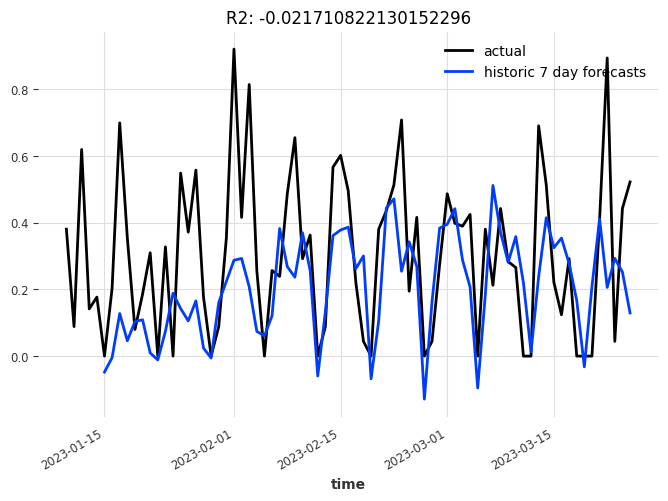

In [58]:
display_forecast(pred_series, data_, "7 day", start_date=hyperparametrizacion.split_value)

In [ ]:
#Guardar los parametros de entrenamiento
handle_loader.save_dict_to_json(file_name='parametros',dict_data=hyperparametrizacion.model_used_parameters,path_to_save=save_parameters.as_posix())
#Guardar el modelo
model.save(str(save_parameters.joinpath('model').with_suffix('.pkl')))
#Listado de archivos en el directorio
for child in save_parameters.iterdir(): print(child)

In [59]:
split_data = '20221111'

In [61]:
pred_series = model.historical_forecasts(
    data_,
    # start=pd.Timestamp("20230107"),
    start=pd.Timestamp(split_data),
    forecast_horizon=1,
    stride=1,
    retrain=False,
    verbose=True,
)

  0%|          | 0/135 [00:00<?, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

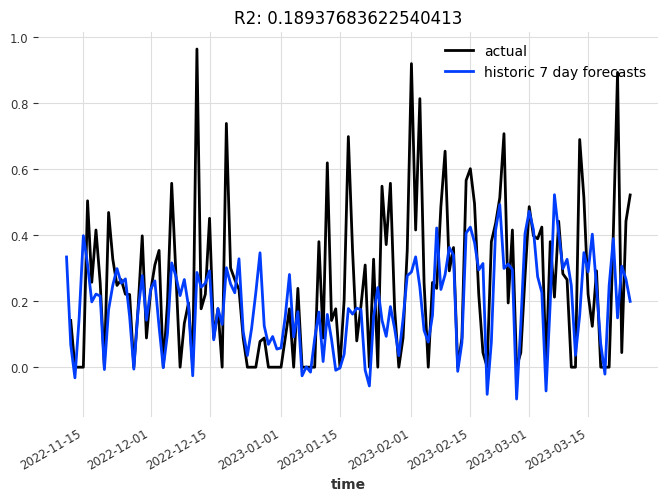

In [62]:
display_forecast(pred_series, data_, "7 day", start_date=pd.Timestamp(split_data))

In [194]:
### Possible N-BEATS hyper-parameters

# Slicing hyper-params:
IN_LEN = 10
OUT_LEN = 4

# Architecture hyper-params:
NUM_STACKS = 10
NUM_BLOCKS = 2
NUM_LAYERS = 3
LAYER_WIDTH = 256
COEFFS_DIM = 12

# Training settings:
LR = 1e-3
BATCH_SIZE = 1024
MAX_SAMPLES_PER_TS = 10
NUM_EPOCHS = 300
NUM_EPOCHS_VALIDATION = 10

model_nbeats = NBEATSModel(
    input_chunk_length=IN_LEN,
    output_chunk_length=OUT_LEN,
    generic_architecture=True,
    num_stacks=NUM_STACKS,
    num_blocks=NUM_BLOCKS,
    num_layers=NUM_LAYERS,
    layer_widths=LAYER_WIDTH,
    n_epochs=NUM_EPOCHS,
    nr_epochs_val_period=NUM_EPOCHS_VALIDATION,
    batch_size=BATCH_SIZE,
    model_name="nbeats_run",
    # optimizer_kwargs={"lr": 1e-3}, #Temporal datos
    # force_reset=True, #Temporal datos
    # save_checkpoints=True, # Temporal datos
    pl_trainer_kwargs={
        "enable_progress_bar": True,
        "accelerator": "gpu",
        # "gpus": -1,
        # "auto_select_gpus": True,
    }
)

split_data ='20230109' #"20230107"

#Separacion de datos para entrenamiento
train, val = data_.split_after(pd.Timestamp(split_data))
model_nbeats.fit(train, val_series=val, verbose=True)
pred_series = model_nbeats.historical_forecasts(
    data_,
    # series_transformed,
    start=pd.Timestamp(split_data),
    forecast_horizon=10,
    stride=1,
    retrain=False,
    verbose=True,
)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

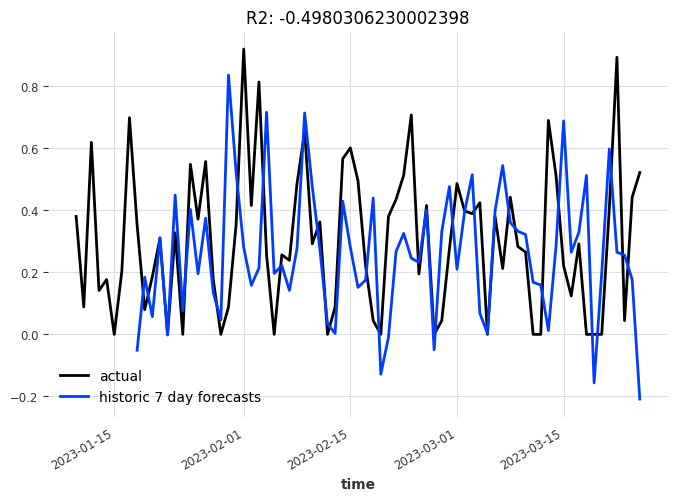

In [195]:
display_forecast(pred_series, data_, "7 day", start_date=pd.Timestamp(split_data))

In [196]:
# # data = data_for_process.dataframe.copy()
# data = filter_data.copy()
# data.reset_index(inplace=True)

# # data.plot(y='Cant Pedido UMV',x='Fecha Creación')

# #Llenado de espacion vacio o faltantes
# filler = MissingValuesFiller()
# data = filler.transform(
#     TimeSeries.from_dataframe(
#         data, "Fecha Creación", ["Cant Pedido UMV"]
#     )
# )

# #Separacion de datos para entrenamiento
# train, val = data.split_after(pd.Timestamp("20230107"))

# #Escalado de datos
# transformer = Scaler()
# train_transformed = transformer.fit_transform(train)
# val_transformed = transformer.transform(val)
# series_transformed = transformer.transform(data)

# #entrenamiento
# model_nbeats.fit(train, val_series=val, verbose=True)
#Predicciones sobre datos
# pred_series = model_nbeats.historical_forecasts(
#     data,
#     # series_transformed,
#     start=pd.Timestamp("20230107"),
#     forecast_horizon=10,
#     stride=1,
#     retrain=False,
#     verbose=True,
# )

In [197]:
split_data ='20221111'

In [198]:
pred_series = model_nbeats.historical_forecasts(
    data_,
    # series_transformed,
    start=pd.Timestamp(split_data),
    forecast_horizon=10,
    stride=1,
    retrain=False,
    verbose=True,
)

  0%|          | 0/126 [00:00<?, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

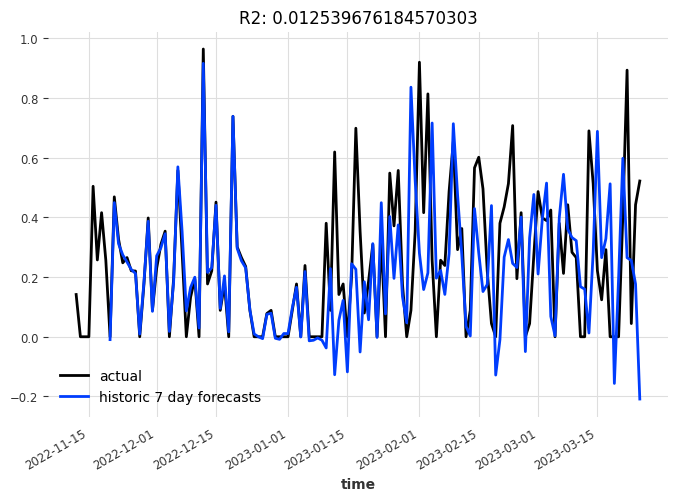

In [199]:
display_forecast(pred_series, data_, "7 day", start_date=pd.Timestamp(split_data))

In [22]:
invers_pred = scalesr.inverse_transform(pred_series)

In [23]:
data_frame_predicciones = invers_pred.pd_dataframe()

In [24]:
# data_frame_predicciones['varianza']abs
data_frame_predicciones['Varianza'] = data_frame_predicciones['Cant Pedido UMV'].pct_change() * 100

In [25]:
data_frame_predicciones

component,Cant Pedido UMV,Varianza
time,,
2023-01-16,402.994966,NaN
2023-01-17,434.945969,7.928388
2023-01-18,-22.591065,-105.193993
2023-01-19,132.718843,-687.483780
2023-01-20,342.239259,157.867875
...,...,...
2023-03-21,443.729884,84.847140
2023-03-22,244.781155,-44.835549
2023-03-23,338.851334,38.430319


In [16]:
import pandas as pd
import numpy as np

# Crea una serie de fechas desde el 1 de enero del 2020 hasta el 31 de diciembre del 2022
dates = pd.date_range('2020-01-01', '2022-12-31')

# Crea datos aleatorios para estas fechas
data = np.random.randn(len(dates))

# Crea un DataFrame de Pandas
df = pd.DataFrame(data, index=dates, columns=['Valor'])

# Calcula la varianza de la columna 'Valor'
df['varianza']= df['Valor'].expanding().var()

print("La varianza es: ", varianza)

La varianza es:  2.085147131696632


In [17]:
df

,Valor,varianza
2020-01-01,-0.546455,NaN
2020-01-02,-1.638226,0.595982
2020-01-03,1.104415,1.906570
2020-01-04,-0.389358,1.271261
2020-01-05,-0.433929,0.954330
...,...,...
2022-12-27,0.569679,1.005138
2022-12-28,0.149524,1.004252
2022-12-29,-0.770879,1.003815
2022-12-30,-1.459098,1.004724


In [7]:
import pandas as pd
import numpy as np

# Crea una serie de fechas desde el 1 de enero del 2020 hasta el 31 de diciembre del 2022
dates = pd.date_range('2020-01-01', '2022-12-31')

# Crea datos aleatorios para estas fechas
data = np.random.randn(len(dates))

# Crea un DataFrame de Pandas
df = pd.DataFrame(data, index=dates, columns=['Valor'])

# Selecciona el rango de fechas
df_subset = df.loc['2021-01-01':'2021-12-31']

# Calcula la varianza del subconjunto
varianza = df_subset['Valor'].var()

print("La varianza para el año 2021 es: ", varianza)


La varianza para el año 2021 es:  1.1026782047196244


In [10]:
df_subset

,Valor
2021-01-01,-0.380122
2021-01-02,0.047412
2021-01-03,0.650249
2021-01-04,-1.218616
2021-01-05,1.263046
...,...
2021-12-27,1.276249
2021-12-28,-0.362999
2021-12-29,1.667382
2021-12-30,-0.654364


In [11]:
import pandas as pd
import numpy as np

# Crea una serie de fechas desde el 1 de enero del 2020 hasta el 31 de diciembre del 2022
dates = pd.date_range('2020-01-01', '2022-12-31')

# Crea datos aleatorios para estas fechas
data = np.random.randn(len(dates))

# Crea un DataFrame de Pandas
df = pd.DataFrame(data, index=dates, columns=['Valor'])

# Calcula la diferencia entre cada fila y la siguiente
df['Diferencia'] = df['Valor'].diff()

# Elimina la primera fila, ya que su diferencia es NaN
df = df.dropna()

# Calcula la varianza de las diferencias
varianza = df['Diferencia'].var()

print("La varianza de las diferencias es: ", varianza)


La varianza de las diferencias es:  2.085147131696632


In [12]:
df

,Valor,Diferencia
2020-01-02,0.812481,0.920745
2020-01-03,-3.544196,-4.356677
2020-01-04,-0.366324,3.177872
2020-01-05,0.282619,0.648942
2020-01-06,-1.215430,-1.498049
...,...,...
2022-12-27,-1.113192,-2.274300
2022-12-28,-0.102095,1.011097
2022-12-29,-1.034648,-0.932553
2022-12-30,-1.764926,-0.730278


In [14]:
import pandas as pd
import numpy as np

# Crea una serie de fechas desde el 1 de enero del 2020 hasta el 31 de diciembre del 2022
dates = pd.date_range('2020-01-01', '2022-12-31')

# Crea datos aleatorios para estas fechas
data = np.random.randn(len(dates))

# Crea un DataFrame de Pandas
df = pd.DataFrame(data, index=dates, columns=['Valor'])

# Calcula la diferencia entre cada fila y la siguiente
df['Diferencia'] = df['Valor'].diff()

# Calcula la varianza de las diferencias hasta ese punto
df['Varianza'] = df['Valor'].expanding().var()

print(df.head())

               Valor  Diferencia  Varianza
2020-01-01  0.318880         NaN       NaN
2020-01-02  0.634320    0.315440  0.049751
2020-01-03  2.416640    1.782321  1.279461
2020-01-04 -1.418394   -3.835034  2.468000
2020-01-05  0.027293    1.445687  1.893425


In [18]:
import pandas as pd

# Creamos un DataFrame de ejemplo
df = pd.DataFrame({'Valores': [50, 75, 100, 125]})

# Calculamos la variación porcentual y multiplicamos por 100 para obtener el porcentaje
df['Varianza'] = df['Valores'].pct_change() * 100

print(df)

   Valores   Varianza
0       50        NaN
1       75  50.000000
2      100  33.333333
3      125  25.000000
